In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("mediumreview.csv")

In [3]:
df.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment,appVersion
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL,NaN
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE,NaN
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE,NaN
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN


In [4]:
df.shape

(49394, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49394 entries, 0 to 49393
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              49394 non-null  object
 1   content               49394 non-null  object
 2   score                 49394 non-null  int64 
 3   thumbsUpCount         49394 non-null  int64 
 4   reviewCreatedVersion  44033 non-null  object
 5   at                    49394 non-null  object
 6   replyContent          2477 non-null   object
 7   repliedAt             2477 non-null   object
 8   predicted_category    49394 non-null  object
 9   sentiment             49394 non-null  object
 10  appVersion            1522 non-null   object
dtypes: int64(2), object(9)
memory usage: 4.1+ MB


In [6]:
df.drop(["repliedAt","replyContent","appVersion","reviewCreatedVersion","reviewId","at"],axis = 1)

,content,score,thumbsUpCount,predicted_category,sentiment
0,woww,5,0,USER_EXPERIENCE,NEUTRAL
1,let me know more details about this,3,0,CONTENT,NEUTRAL
2,i've been using this for a while and there's a...,2,0,INTERFACE,NEGATIVE
3,good,2,0,USER_EXPERIENCE,POSITIVE
4,mjkobe,5,0,USER_EXPERIENCE,NEUTRAL
...,...,...,...,...,...
49389,like,5,1,USER_EXPERIENCE,NEUTRAL
49390,loving it so far,5,0,USER_EXPERIENCE,POSITIVE
49391,guidance is from allah,1,0,USER_EXPERIENCE,NEUTRAL
49392,nice project,5,0,USER_EXPERIENCE,POSITIVE


In [7]:
df["sentiment"].value_counts()

POSITIVE    37248
NEUTRAL      6603
NEGATIVE     5543
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='score', ylabel='count'>

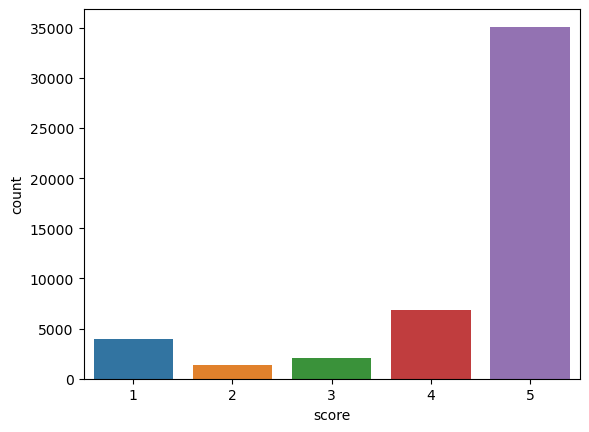

In [8]:

import seaborn as sns
sns.countplot(x='score', data = df)

In [9]:
# Selecting the text and Target column for our further analysis
data = df[["score","content"]]

In [10]:
data['score'].unique()

array([5, 3, 2, 1, 4], dtype=int64)

In [11]:
data_pos = data[data['score'] == 5]
data_pos = data[data['score'] == 4]
data_neg = data[data['score'] == 2]
data_neg = data[data['score'] == 1]

In [12]:
data_pos = data_pos.iloc[:int(10000)]
data_neg = data_neg.iloc[:int(10000)]

In [13]:
dataset = pd.concat([data_pos, data_neg])

In [14]:
dataset['content']=dataset['content'].str.lower()
dataset['content'].tail()


49345                                             good
49352                good work you people really tried
49362                     why to pay to gain knowledge
49383    can't create an account... it goes in circles
49391                           guidance is from allah
Name: content, dtype: object

In [15]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 
            'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [16]:

STOPWORDS = set(stopwordlist)
def clean_stopwords(content):
    return " ". join([word for word in str (content).split() if word not in STOPWORDS])
dataset["content"] = dataset["content"].apply(lambda content : clean_stopwords(content))
dataset["content"].head()



11    wonderful app, managers, editorial staffs idea...
23                                     it's really good
30                                           very. good
36    enjoy reading articles writing advice given he...
48    nice reccomendation system infinite amount top...
Name: content, dtype: object

In [17]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['content']= dataset['content'].apply(lambda x: cleaning_punctuations(x))
dataset['content'].head()



11    wonderful app managers editorial staffs idea b...
23                                      its really good
30                                            very good
36    enjoy reading articles writing advice given he...
48    nice reccomendation system infinite amount top...
Name: content, dtype: object

In [18]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['content'] = dataset['content'].apply(lambda x: cleaning_repeating_char(x))
dataset['content'].head()


11    wonderful app managers editorial staffs idea b...
23                                      its really good
30                                            very good
36    enjoy reading articles writing advice given he...
48    nice reccomendation system infinite amount top...
Name: content, dtype: object

In [19]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['content'] = dataset['content'].apply(lambda x: cleaning_numbers(x))
dataset['content'].head()
=

11    wonderful app managers editorial staffs idea b...
23                                      its really good
30                                            very good
36    enjoy reading articles writing advice given he...
48    nice reccomendation system infinite amount top...
Name: content, dtype: object

In [20]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['content'] = dataset['content'].apply(tokenizer.tokenize)
dataset['content'].head()


11    [wonderful, app, managers, editorial, staffs, ...
23                                  [its, really, good]
30                                         [very, good]
36    [enjoy, reading, articles, writing, advice, gi...
48    [nice, reccomendation, system, infinite, amoun...
Name: content, dtype: object

In [21]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['content']= dataset['content'].apply(lambda x: stemming_on_text(x))
dataset['content'].head()


11    [wonderful, app, managers, editorial, staffs, ...
23                                  [its, really, good]
30                                         [very, good]
36    [enjoy, reading, articles, writing, advice, gi...
48    [nice, reccomendation, system, infinite, amoun...
Name: content, dtype: object

In [22]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\prati\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:

import nltk

# Initialize the WordNetLemmatizer
lm = nltk.WordNetLemmatizer()

# Assuming 'dataset' is your DataFrame containing the 'content' column

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text  # Return the lemmatized text, not the original data

# Apply lemmatization to the 'content' column
dataset['content'] = dataset['content'].apply(lambda x: lemmatizer_on_text(x))

# Display the modified 'content' column
print(dataset['content'].head())


11    [wonderful, app, manager, editorial, staff, id...
23                                   [it, really, good]
30                                         [very, good]
36    [enjoy, reading, article, writing, advice, giv...
48    [nice, reccomendation, system, infinite, amoun...
Name: content, dtype: object


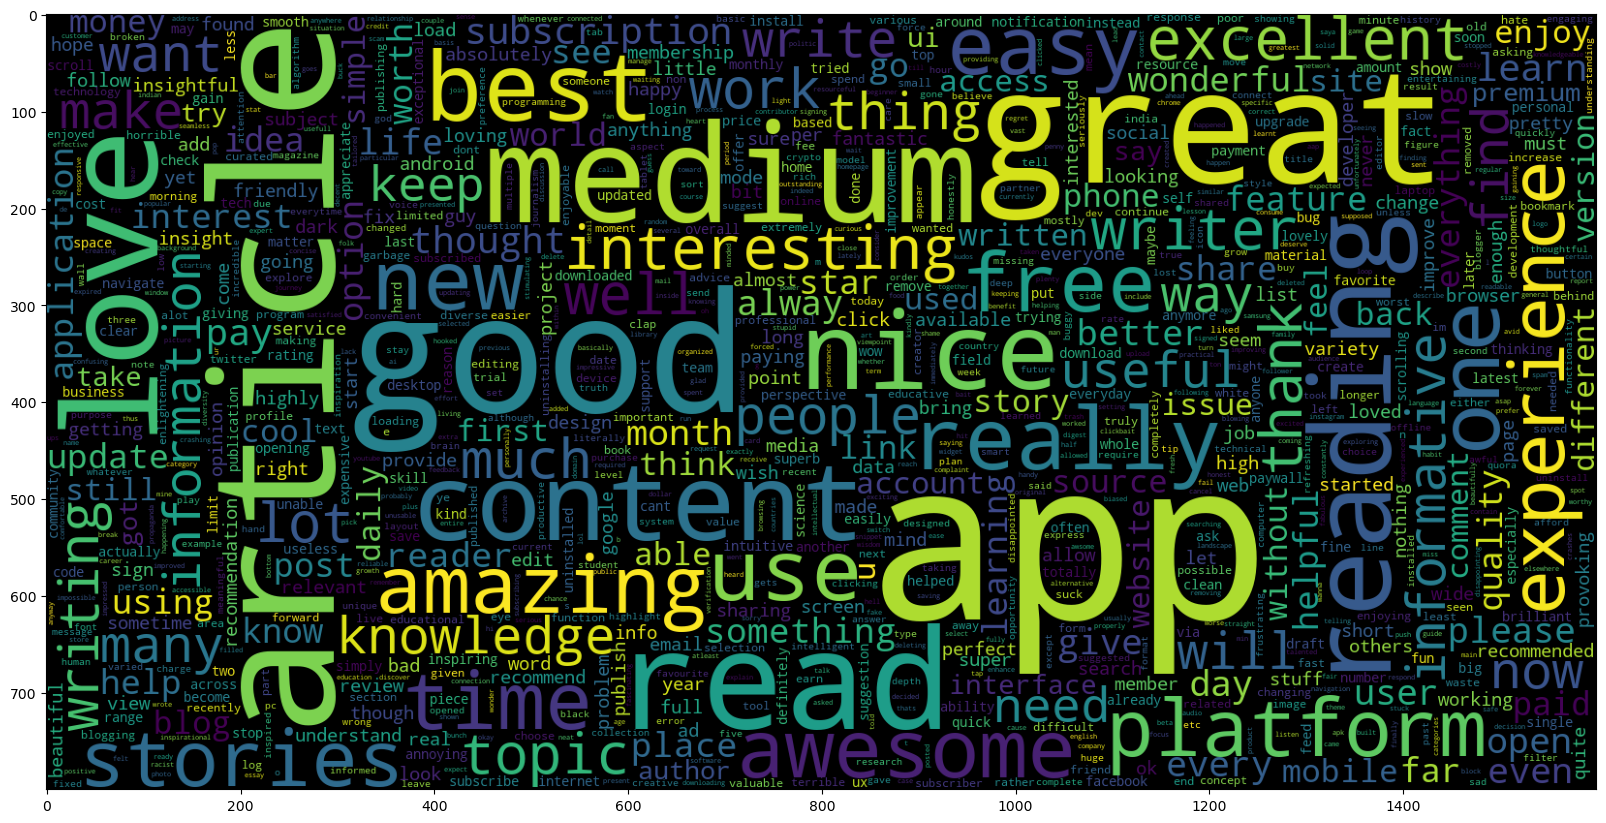

In [24]:
data_neg = data['content'][:20000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

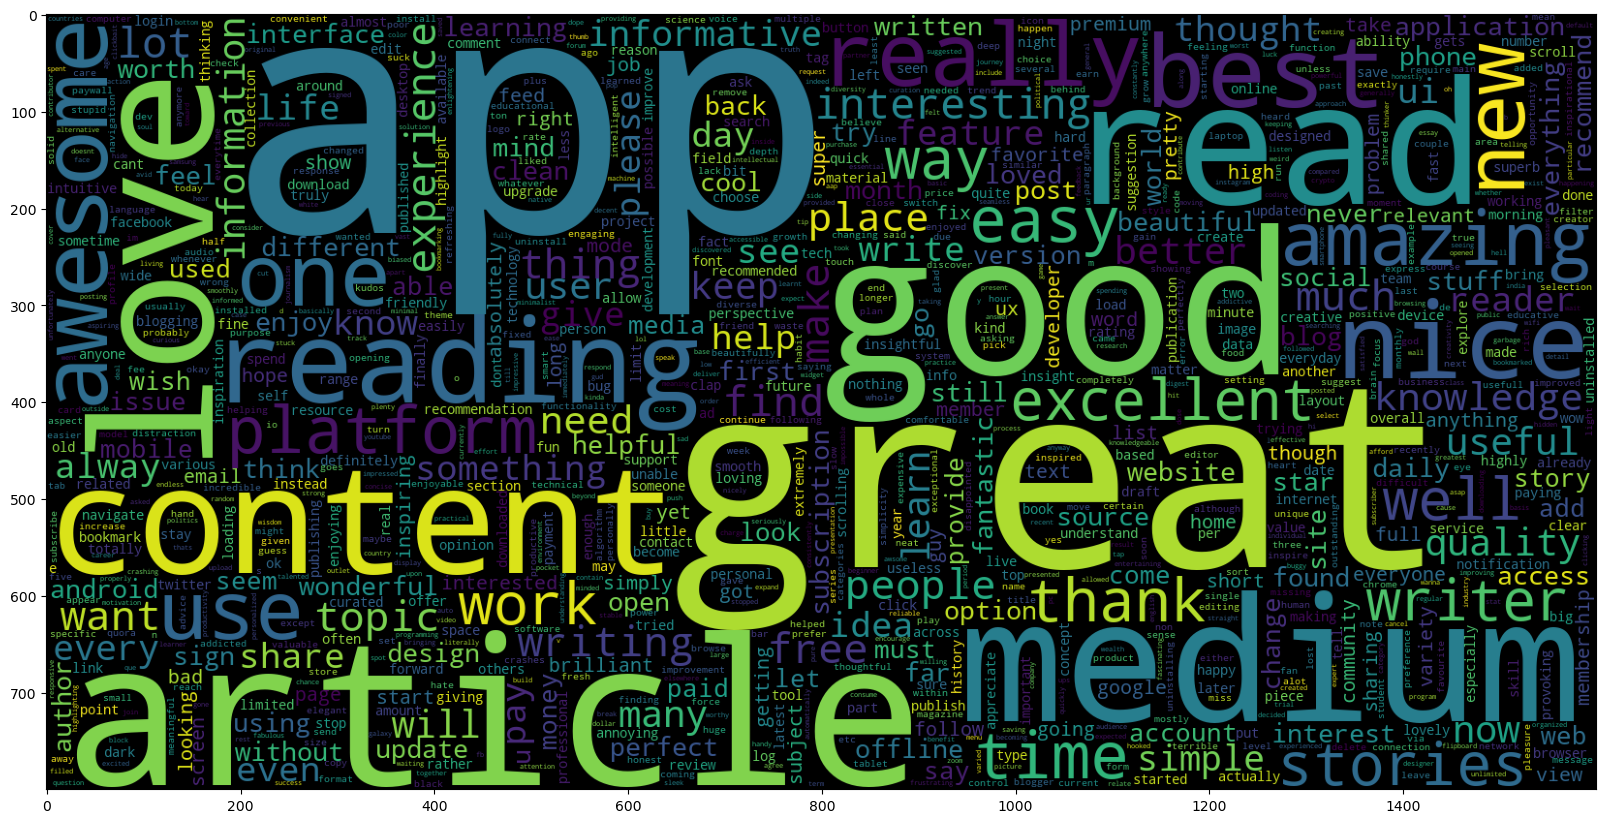

In [25]:
data_pos = data['content'][20000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [26]:
X = df['content']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [27]:
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train.astype('U'))  # Convert to Unicode
X_test_vec = vectorizer.transform(X_test.astype('U'))

In [28]:
X_train = X_train_vec
X_test  = X_test_vec

In [29]:
def model_Evaluate(model):
    # Predict values for Test dataset
 y_pred = model.predict(X_test)

In [30]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

In [31]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

    NEGATIVE       0.46      0.60      0.52       810
     NEUTRAL       0.58      0.68      0.63      1009
    POSITIVE       0.95      0.88      0.91      5591

    accuracy                           0.82      7410
   macro avg       0.66      0.72      0.69      7410
weighted avg       0.85      0.82      0.83      7410



In [32]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [33]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.76      0.79       810
     NEUTRAL       0.69      0.64      0.67      1009
    POSITIVE       0.94      0.96      0.95      5591

    accuracy                           0.89      7410
   macro avg       0.81      0.79      0.80      7410
weighted avg       0.89      0.89      0.89      7410



In [34]:

from sklearn.model_selection import GridSearchCV

In [36]:
# Hyperparameter tuning for SVC using GridSearchCV
param_grid_svc = {'C': [0.1, 1, 10]}
grid_search_svc = GridSearchCV(SVCmodel, param_grid_svc, cv=3)
grid_search_svc.fit(X_train, y_train)
best_svc_classifier = grid_search_svc.best_estimator_


In [37]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist_rf = {
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}

In [39]:
random_search_rf = RandomizedSearchCV(rf_classifier, param_dist_rf, n_iter=5, cv=3, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf_classifier = random_search_rf.best_estimator_

In [40]:

# Ensemble method using VotingClassifier
from sklearn.ensemble import VotingClassifier

ensemble_classifier = VotingClassifier(
    estimators=[('svc', best_svc_classifier), ('rf', best_rf_classifier)],
    voting='hard'  # You can also use 'soft' voting
)

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
# Fit the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8963562753036437


In [44]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [45]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.75      0.78       810
     NEUTRAL       0.71      0.63      0.67      1009
    POSITIVE       0.93      0.96      0.95      5591

    accuracy                           0.89      7410
   macro avg       0.82      0.78      0.80      7410
weighted avg       0.89      0.89      0.89      7410

